In [1]:
using Pkg
Pkg.activate("./../../development/Oceananigans.jl")
Pkg.instantiate()
using Oceananigans, CairoMakie

  Activating project at `~/development/Oceananigans.jl`
┌ Warning: You are using Julia v1.11 or later!"
│ Oceananigans is currently tested on Julia v1.10."
│ If you find issues with Julia v1.11 or later,"
│ please report at https://github.com/CliMA/Oceananigans.jl/issues/new
└ @ Oceananigans ~/development/Oceananigans.jl/src/Oceananigans.jl:125
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0] (cache misses: wrong dep version loaded (4), incompatible header (4), dep missing source (4), mismatched flags (4))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


In [2]:
using Statistics: mean

function get_dissipation(filename)
    Abxt = FieldTimeSeries(filename, "Abx")
    Abyt = FieldTimeSeries(filename, "Aby")
    Abzt = FieldTimeSeries(filename, "Abz")

    Gbxt = FieldTimeSeries(filename, "Gbx")
    Gbyt = FieldTimeSeries(filename, "Gby")
    Gbzt = FieldTimeSeries(filename, "Gbz")
    Dbzt = FieldTimeSeries(filename, "Dbz")

    grid  = Abxt.grid
    times = Abxt.times
    Nx, Ny, Nz = size(grid)    
    VFCC = KernelFunctionOperation{Face, Center, Center}(Oceananigans.Operators.Vᶠᶜᶜ, grid)
    VCFC = KernelFunctionOperation{Center, Face, Center}(Oceananigans.Operators.Vᶜᶠᶜ, grid)
    VCCF = KernelFunctionOperation{Center, Center, Face}(Oceananigans.Operators.Vᶜᶜᶠ, grid)

    VFCC = compute!(Field(VFCC))
    VCFC = compute!(Field(VCFC))
    VCCF = compute!(Field(VCCF))
    
    Abx = FieldTimeSeries{Nothing, Center, Center}(grid, times)
    Aby = FieldTimeSeries{Nothing, Face,   Center}(grid, times)
    Abz = FieldTimeSeries{Nothing, Center, Face}(grid, times)
    Gbx = FieldTimeSeries{Nothing, Center, Center}(grid, times)
    Gby = FieldTimeSeries{Nothing, Face,   Center}(grid, times)
    Gbz = FieldTimeSeries{Nothing, Center, Face}(grid, times)
    Dbz = FieldTimeSeries{Nothing, Center, Face}(grid, times)

    for t in eachindex(times)
        set!(Abx[t], mean(Abxt[t], dims=1))
        set!(Aby[t], mean(Abyt[t], dims=1))
        set!(Abz[t], mean(Abzt[t], dims=1))
        set!(Gbx[t], mean(Gbxt[t], dims=1))
        set!(Gby[t], mean(Gbyt[t], dims=1))
        interior(Gby[t], :, 1, :) .= interior(Gby[t], :, 2, :) 
        interior(Gby[t], :, Ny+1, :) .= interior(Gby[t], :, Ny, :) 
        set!(Gbz[t], mean(Gbzt[t], dims=1))
        set!(Dbz[t], mean(Dbzt[t], dims=1))
    end
    
    return (; Abx, Aby, Abz, Gbx, Gby, Gbz, Dbz)
end

get_dissipation (generic function with 1 method)

In [6]:
# TSP is the timestepper (0 => AB2, 1 => RK3)
# ZST is the z coord     (0 => Zstar, 1 => Zcoordinate)
# MOM is the mom advect  (0 => WENOVectorInvariant,
#                         1 => VectorInvariant,
#                         2 => WENOVectorInvariant Centered advecting velocity)
# CLO is the z closure   (0 => CA, 1 => CATKE, 2 => RiBased)
# TRA is the tracer adv  (0 => WENO7 buffered to WENO5 then Centered,
#                         1 => (x, y => WENO5, z => Centered),
#                         2 => (x, y => WENO9, z => Centered),
#                         3 => Upwind3,
#                         4 => (x, y => Upwind3, z => Centered),
#                         5 => WENO5)

# EXP = string(CLO) * string(MOM) * string(TRA) * string(TSP) * string(ZST)

f1 = "timesteppers/averages_10000.jld2"
f2 = "timesteppers/averages_10010.jld2"
f3 = "timesteppers/averages_10310.jld2"

al = get_dissipation(f1); # -> RED!!!
rl = get_dissipation(f2); # -> BLUE!!!
r3 = get_dissipation(f3); # -> GREEN!!!

In [7]:
function add_dissipation(case)
    κx = compute!(Field(mean(- case.Abx[end], dims = (1, 2)) / mean(case.Gbx[end], dims = (1, 2)) / 2))
    κy = compute!(Field(mean(- case.Aby[end], dims = (1, 2)) / mean(case.Gby[end], dims = (1, 2)) / 2))
    κz = compute!(Field(mean(- case.Abz[end], dims = (1, 2)) / mean(case.Gbz[end], dims = (1, 2)) / 2))
    κd = compute!(Field(mean(- case.Dbz[end], dims = (1, 2)) / mean(case.Gbz[end], dims = (1, 2)) / 2))
    
    sG = case.Gbx[end] + case.Gby[end] + case.Gbz[end]
    
    κxz = compute!(Field(mean(- case.Abx[end], dims = (1, 2)) / mean(sG, dims = (1, 2)) / 2))
    κyz = compute!(Field(mean(- case.Aby[end], dims = (1, 2)) / mean(sG, dims = (1, 2)) / 2))
    κzz = compute!(Field(mean(- case.Abz[end], dims = (1, 2)) / mean(sG, dims = (1, 2)) / 2))

    return merge(case, (; κx, κy, κz, κd, κxz, κyz, κzz))
end

add_dissipation (generic function with 1 method)

In [9]:
al = add_dissipation(al);
rl = add_dissipation(rl);
r3 = add_dissipation(r3);

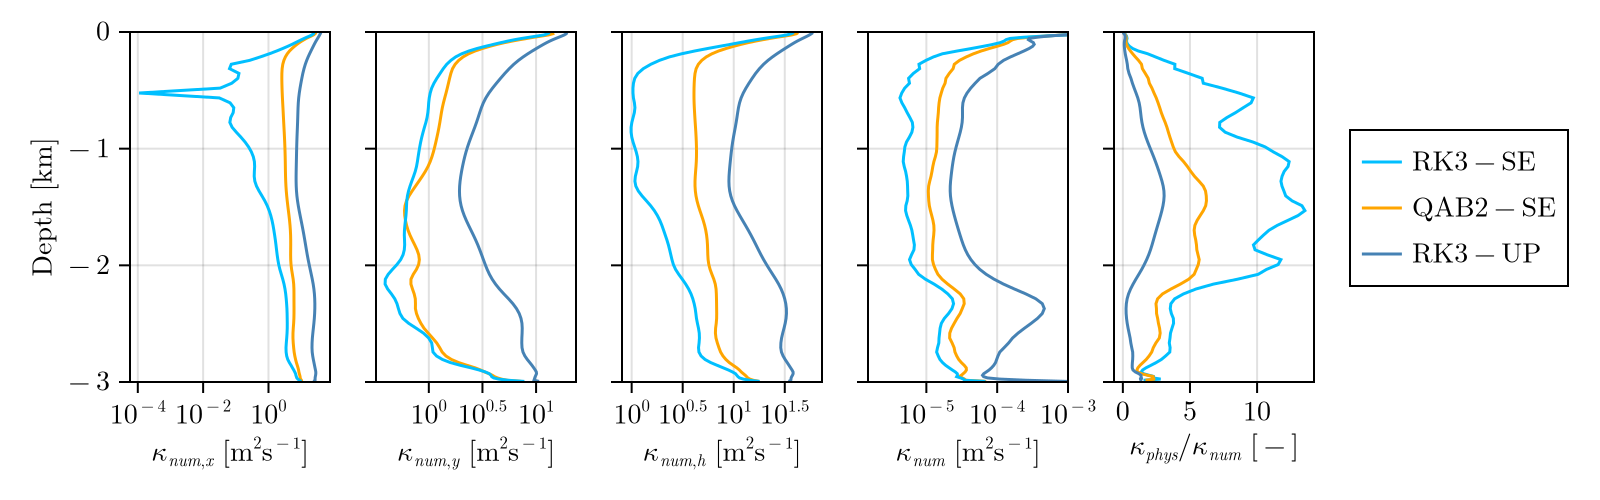

CairoMakie.Screen{PDF}


In [76]:
zC = al.Abx.grid.z.cᵃᵃᶜ[1:90] ./ 1000
zF = al.Abx.grid.z.cᵃᵃᶠ[1:91] ./ 1000

c1 = :deepskyblue 
c2 = :blue
c3 = :orange1 
c4 = :steelblue

using LaTeXStrings

ticks(vec) = (vec, latexstring.(string.(vec)))

fig = Figure(size = (800, 250))

xt1 = ([1e-4, 1e-2, 1], [L"10^{-4}", L"10^{-2}", L"10^0"])
xt2 = ([1e+0, 10^(0.5), 10], [L"10^{0}", L"10^{0.5}", L"10^1"])
xt3 = ([1e+0, 10^(0.5), 10, 10^1.5], [L"10^{0}", L"10^{0.5}", L"10^1", L"10^{1.5}"])
xt4 = ([0, 2e-5, 4e-5], [L"0", L"2\cdot 10^{-5}", L"4\cdot 10^{-5}"])
xt5 = ([1e-5, 1e-4, 1e-3, 1e-2], [L"10^{-5}", L"10^{-4}", L"10^{-3}", L"10^{-2}"])
xt6 = ticks([0, 5, 10])

xl1 = L"\kappa_{num, x} \text{ [m}^2\text{s}^{-1}\text{]}"
xl2 = L"\kappa_{num, y} \text{ [m}^2\text{s}^{-1}\text{]}"
xl3 = L"\kappa_{num, h} \text{ [m}^2\text{s}^{-1}\text{]}"
xl5 = L"\kappa_{num} \text{ [m}^2\text{s}^{-1}\text{]}"
xl6 = L"\kappa_{phys} / \kappa_{num} \text{ [-]}"

ax1 = Axis(fig[1, 1]; xlabel=xl1, xticks=xt1, ylabel = L"\text{Depth [km]}", yticks = ticks([-3, -2, -1, 0]), xscale = log10)
ax2 = Axis(fig[1, 2]; xlabel=xl2, xticks=xt2, ylabel = "", yticks = ([-3, -2, -1, 0], ["", "", "", ""]), xscale = log10)
ax3 = Axis(fig[1, 3]; xlabel=xl3, xticks=xt3, ylabel = "", yticks = ([-3, -2, -1, 0], ["", "", "", ""]), xscale=log10)
ax5 = Axis(fig[1, 4]; xlabel=xl5, xticks=xt5, ylabel = "", yticks = ([-3, -2, -1, 0], ["", "", "", ""]), xscale=log10)
ax6 = Axis(fig[1, 5]; xlabel=xl6, xticks=xt6, ylabel = "", yticks = ([-3, -2, -1, 0], ["", "", "", ""]))

lines!(ax1, abs.(interior(al.κx, 1, 1, :)), zC, color=c3)
lines!(ax1, abs.(interior(rl.κx, 1, 1, :)), zC, color=c1)
lines!(ax1, abs.(interior(r3.κx, 1, 1, :)), zC, color=c4)

lines!(ax2, abs.(interior(al.κy, 1, 1, :)), zC, color=c3)
lines!(ax2, abs.(interior(rl.κy, 1, 1, :)), zC, color=c1)
lines!(ax2, abs.(interior(r3.κy, 1, 1, :)), zC, color=c4)

lines!(ax3, abs.(interior(al.κx, 1, 1, :) .+ interior(al.κy, 1, 1, :)), zC, color=c3)
lines!(ax3, abs.(interior(rl.κx, 1, 1, :) .+ interior(rl.κy, 1, 1, :)), zC, color=c1)
lines!(ax3, abs.(interior(r3.κx, 1, 1, :) .+ interior(r3.κy, 1, 1, :)), zC, color=c4)

lines!(ax5, abs.(interior(al.κxz, 1, 1, :) + interior(al.κyz, 1, 1, :) + interior(al.κzz, 1, 1, 1:90)), zC, color=c3)
lines!(ax5, abs.(interior(rl.κxz, 1, 1, :) + interior(rl.κyz, 1, 1, :) + interior(rl.κzz, 1, 1, 1:90)), zC, color=c1)
lines!(ax5, abs.(interior(r3.κxz, 1, 1, :) + interior(r3.κyz, 1, 1, :) + interior(r3.κzz, 1, 1, 1:90)), zC, color=c4)
# lines!(ax5, zC ./ zC * 5e-6, zC, color=:grey, linestyle=:dash, linewidth=0.8)
xlims!(ax5, 1.5e-6, 1e-3)

κtrl = abs.(interior(rl.κxz, 1, 1, :) + interior(rl.κyz, 1, 1, :) + interior(rl.κzz, 1, 1, 1:90))
κtal = abs.(interior(al.κxz, 1, 1, :) + interior(al.κyz, 1, 1, :) + interior(al.κzz, 1, 1, 1:90))
κtr3 = abs.(interior(r3.κxz, 1, 1, :) + interior(r3.κyz, 1, 1, :) + interior(r3.κzz, 1, 1, 1:90))

lines!(ax6, abs.(interior(rl.κd, 1, 1, 1:90)) ./ κtrl, zC, color=c1, label=L"\text{RK3-SE}")
lines!(ax6, abs.(interior(al.κd, 1, 1, 1:90)) ./ κtal, zC, color=c3, label=L"\text{QAB2-SE}")
lines!(ax6, abs.(interior(r3.κd, 1, 1, 1:90)) ./ κtr3, zC, color=c4, label=L"\text{RK3-UP}")

Legend(fig[1, 6], ax6)
ylims!(ax1, -3, 0)
ylims!(ax2, -3, 0)
ylims!(ax3, -3, 0)
ylims!(ax5, -3, 0)
ylims!(ax6, -3, 0)
path = "/Users/simonesilvestri/Dropbox (MIT)/Apps/Overleaf/timestepper/"

display(current_figure())
CairoMakie.save(path * "dissipation-channel.pdf", fig)

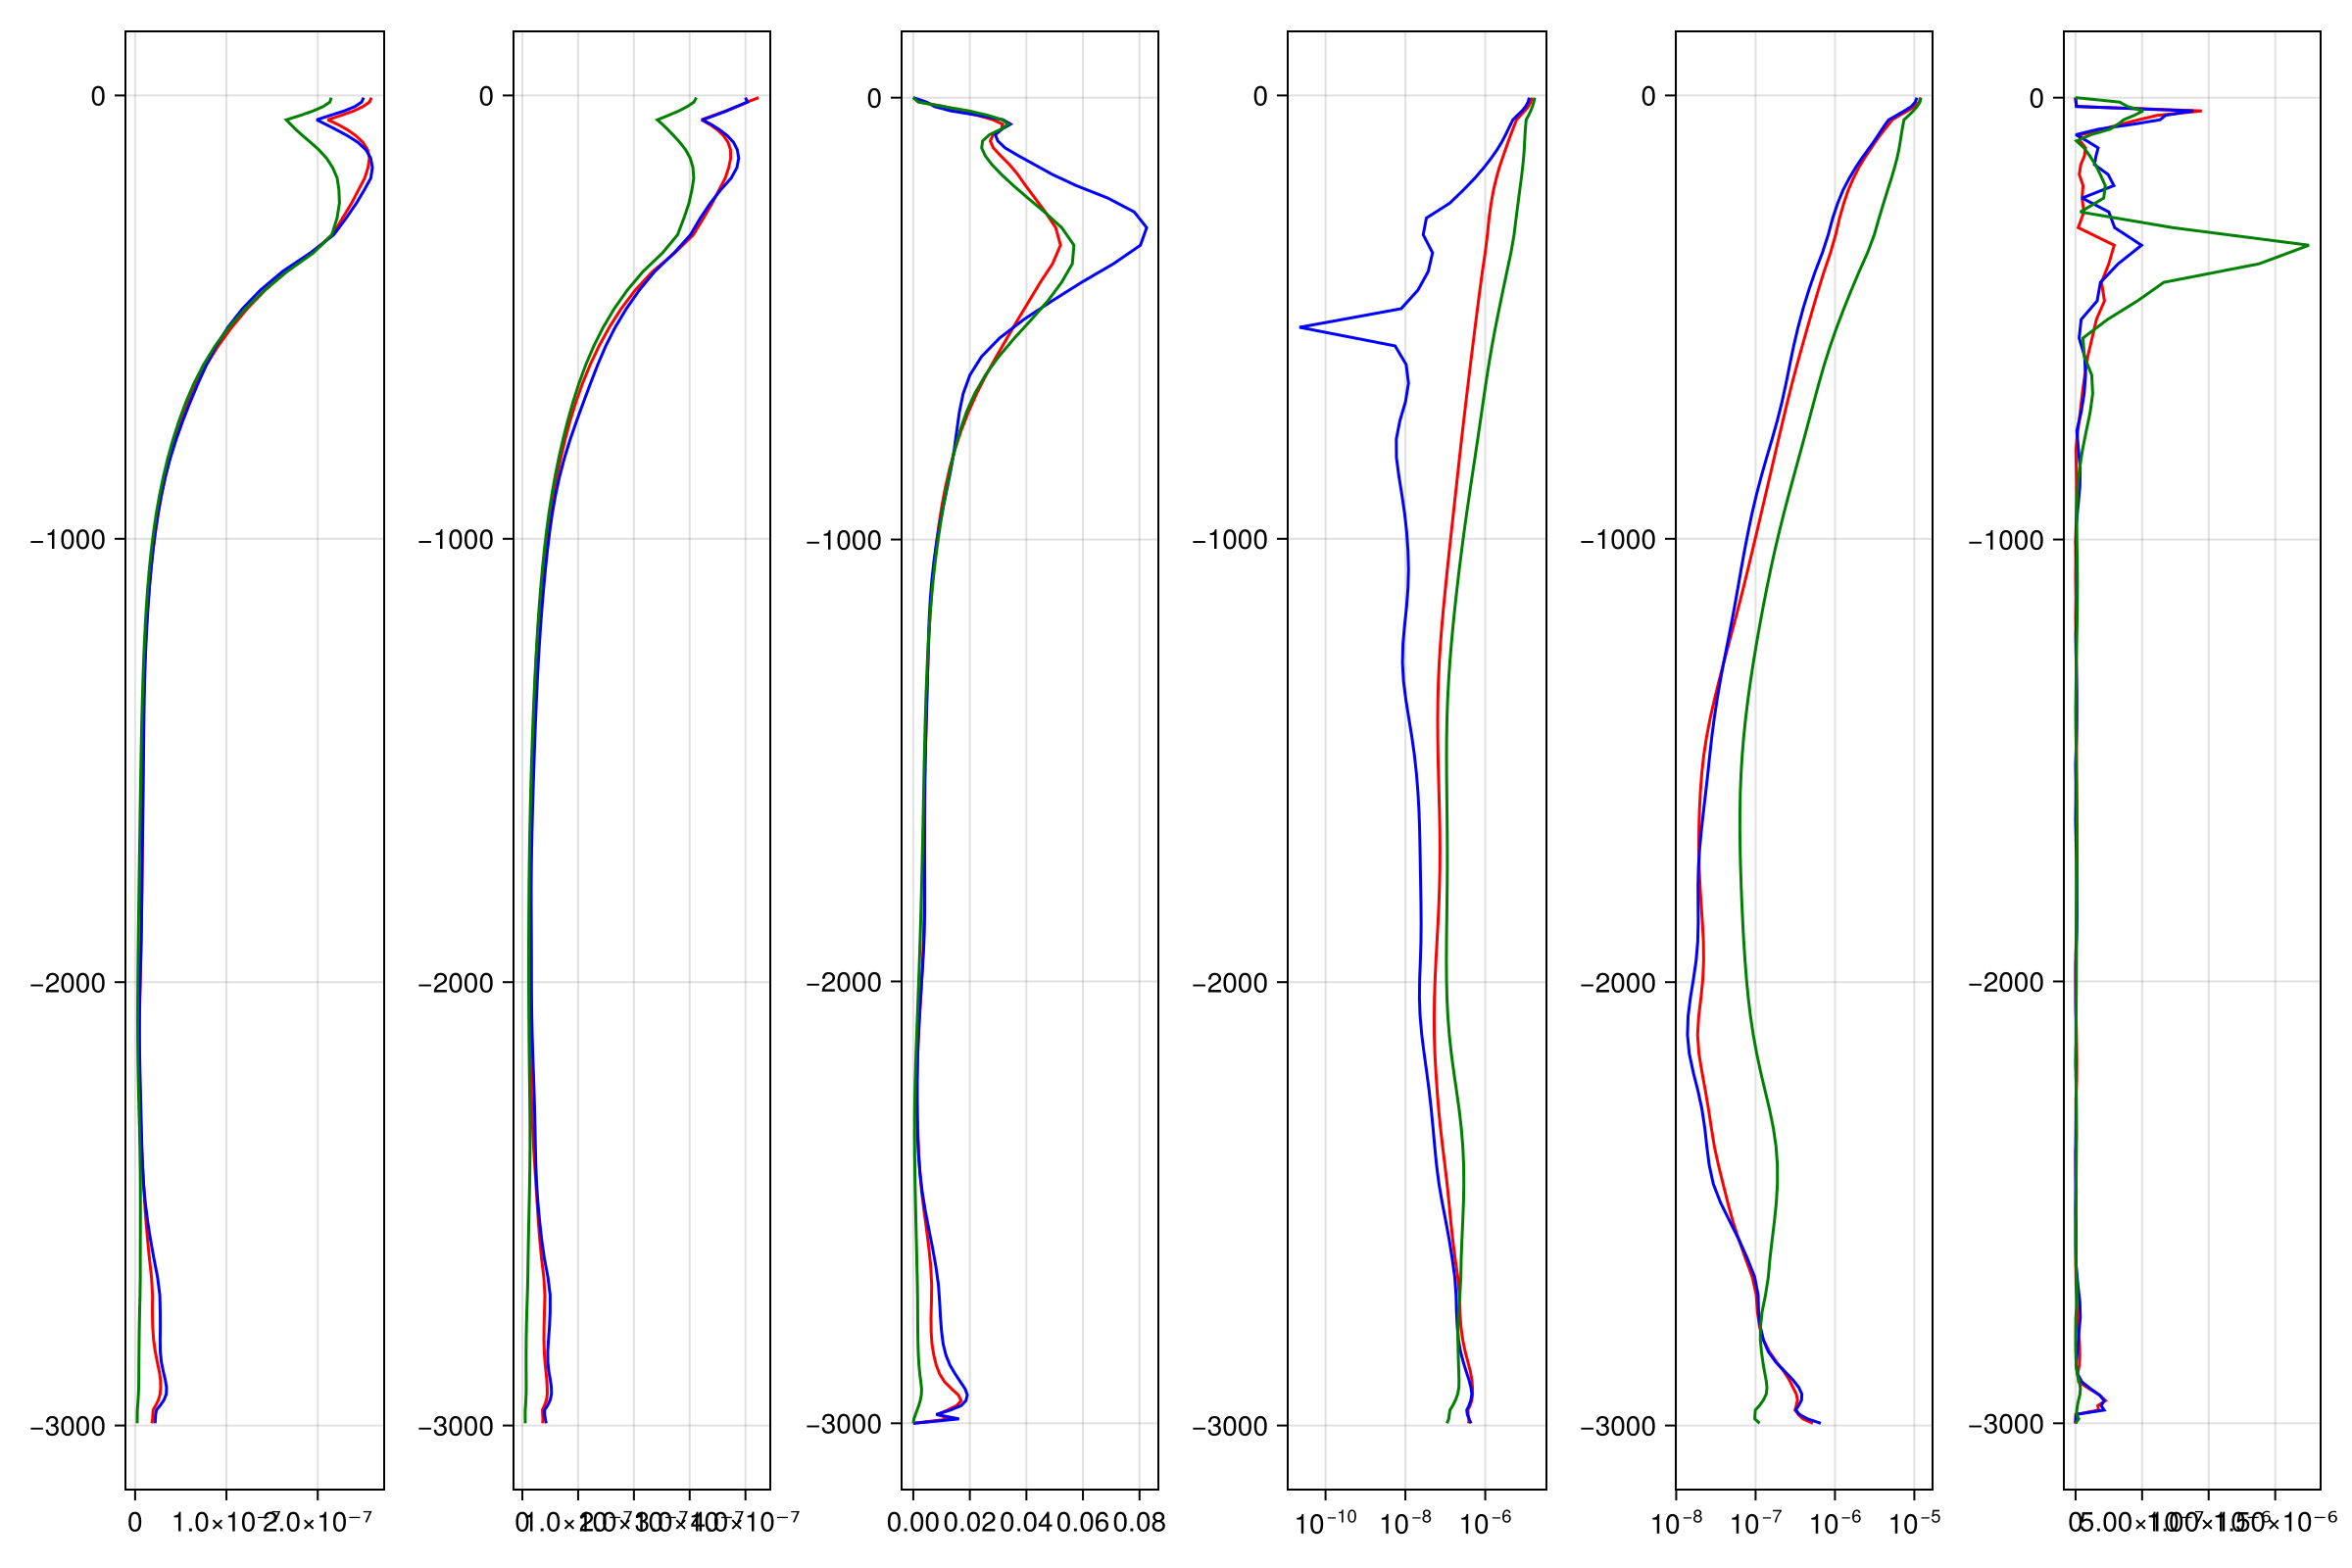

CairoMakie.Screen{IMAGE}


In [47]:
fig = Figure(size = (1200, 800))
ax = Axis(fig[1, 1]) #, xscale = log10)
lines!(ax, interior(mean(al.Gbx[end], dims=(1,2)), 1, 1, :), zC, color=c3)
lines!(ax, interior(mean(rl.Gbx[end], dims=(1,2)), 1, 1, :), zC, color=c1)
lines!(ax, interior(mean(r3.Gbx[end], dims=(1,2)), 1, 1, :), zC, color=c4)
# lines!(ax, interior(mean(cM.Gbx, dims=(1,2)), 1, 1, :),      zC, color=:purple, linestyle=:dashdot)
# xlims!(ax, (1e-11, 1e-5))
ax = Axis(fig[1, 2]) #, xscale = log10)
lines!(ax, interior(mean(al.Gby[end], dims=(1,2)), 1, 1, :), zC, color=c3)
lines!(ax, interior(mean(rl.Gby[end], dims=(1,2)), 1, 1, :), zC, color=c1)
lines!(ax, interior(mean(r3.Gby[end], dims=(1,2)), 1, 1, :), zC, color=c4)
# lines!(ax, interior(mean(cM.Gby, dims=(1,2)), 1, 1, :),      zC, color=c3)
# xlims!(ax, (1e-11, 1e-5))
ax = Axis(fig[1, 3]) #, xscale = log10)
lines!(ax, interior(mean(al.Gbz[end], dims=(1,2)), 1, 1, :), zF, color=c3)
lines!(ax, interior(mean(rl.Gbz[end], dims=(1,2)), 1, 1, :), zF, color=c1)
lines!(ax, interior(mean(r3.Gbz[end], dims=(1,2)), 1, 1, :), zF, color=c4)
# lines!(ax, interior(mean(cM.Gbz, dims=(1,2)), 1, 1, :),      zF, color=:purple, linestyle=:dashdot)
# xlims!(ax, (1e-5, 1e0))
ax = Axis(fig[1, 4] , xscale=log10)
lines!(ax, abs.(interior(mean(al.Abx[end], dims=(1,2)), 1, 1, :)), zC, color=c3)
lines!(ax, abs.(interior(mean(rl.Abx[end], dims=(1,2)), 1, 1, :)), zC, color=c1)
lines!(ax, abs.(interior(mean(r3.Abx[end], dims=(1,2)), 1, 1, :)), zC, color=c4)
# lines!(ax, abs.(interior(mean(cM.Abx, dims=(1,2)), 1, 1, :)     ), zC, color=:purple, linestyle=:dashdot)
# xlims!(ax, (1e-10, 1e-5))
ax = Axis(fig[1, 5] , xscale=log10)
lines!(ax, abs.(interior(mean(al.Aby[end], dims=(1,2)), 1, 1, :)), zC, color=c3)
lines!(ax, abs.(interior(mean(rl.Aby[end], dims=(1,2)), 1, 1, :)), zC, color=c1)
lines!(ax, abs.(interior(mean(r3.Aby[end], dims=(1,2)), 1, 1, :)), zC, color=c4)
# lines!(ax, abs.(interior(mean(cM.Aby, dims=(1,2)), 1, 1, :)     ), zC, color=:purple, linestyle=:dashdot)
# xlims!(ax, (1e-10, 1e-5))
ax = Axis(fig[1, 6])# , xscale=log10)
lines!(ax, abs.(interior(mean(al.Abz[end], dims=(1,2)), 1, 1, :)), zF, color=c3)
lines!(ax, abs.(interior(mean(rl.Abz[end], dims=(1,2)), 1, 1, :)), zF, color=c1)
lines!(ax, abs.(interior(mean(r3.Abz[end], dims=(1,2)), 1, 1, :)), zF, color=c4)
# lines!(ax, abs.(interior(mean(cM.Abz, dims=(1,2)), 1, 1, :)     ), zF, color=:purple, linestyle=:dashdot)
# xlims!(ax, (1e-10, 1e-5))

display(current_figure())

In [35]:
function add_mean_fields(case, filename)
    b = FieldTimeSeries(filename, "b")
    u = FieldTimeSeries(filename, "u")
    v = FieldTimeSeries(filename, "v")
    
    return merge(case, (; b, u, v))
end

add_mean_fields (generic function with 1 method)

In [36]:
al = add_mean_fields(al, f1);
rl = add_mean_fields(rl, f2);
r3 = add_mean_fields(r3, f3);

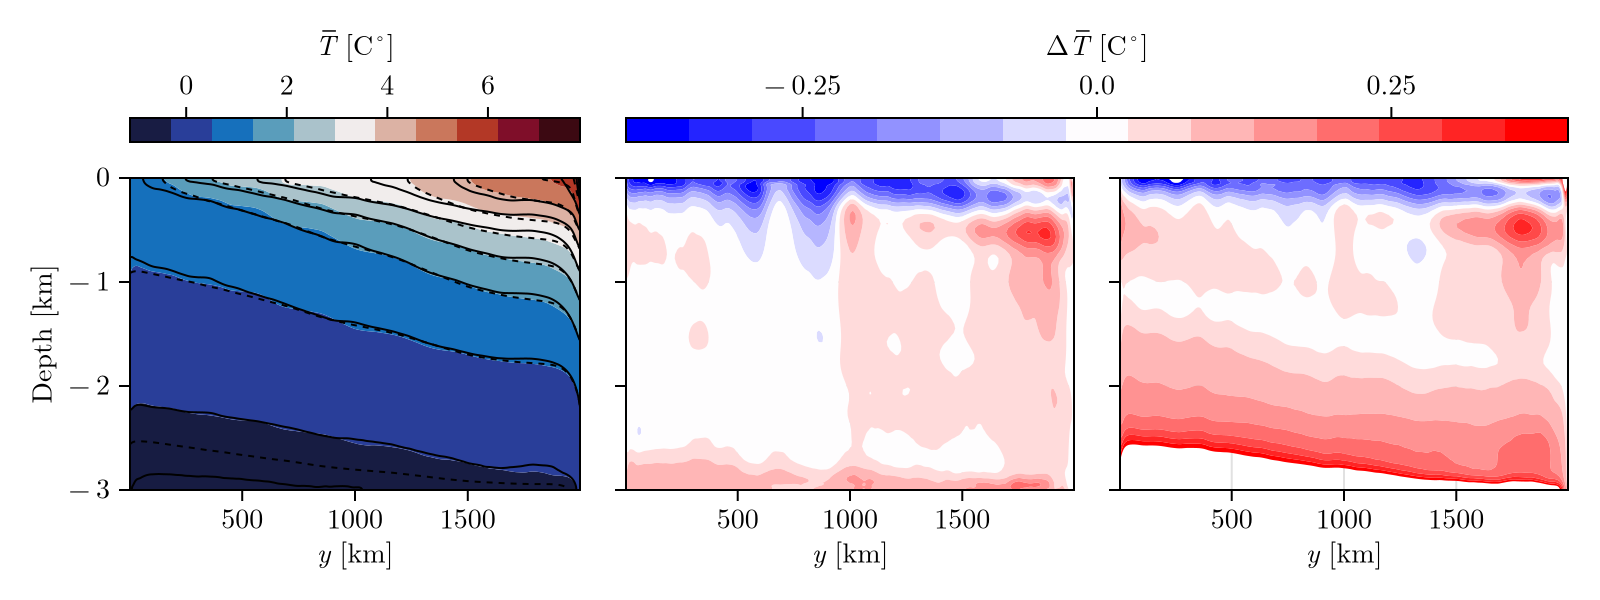

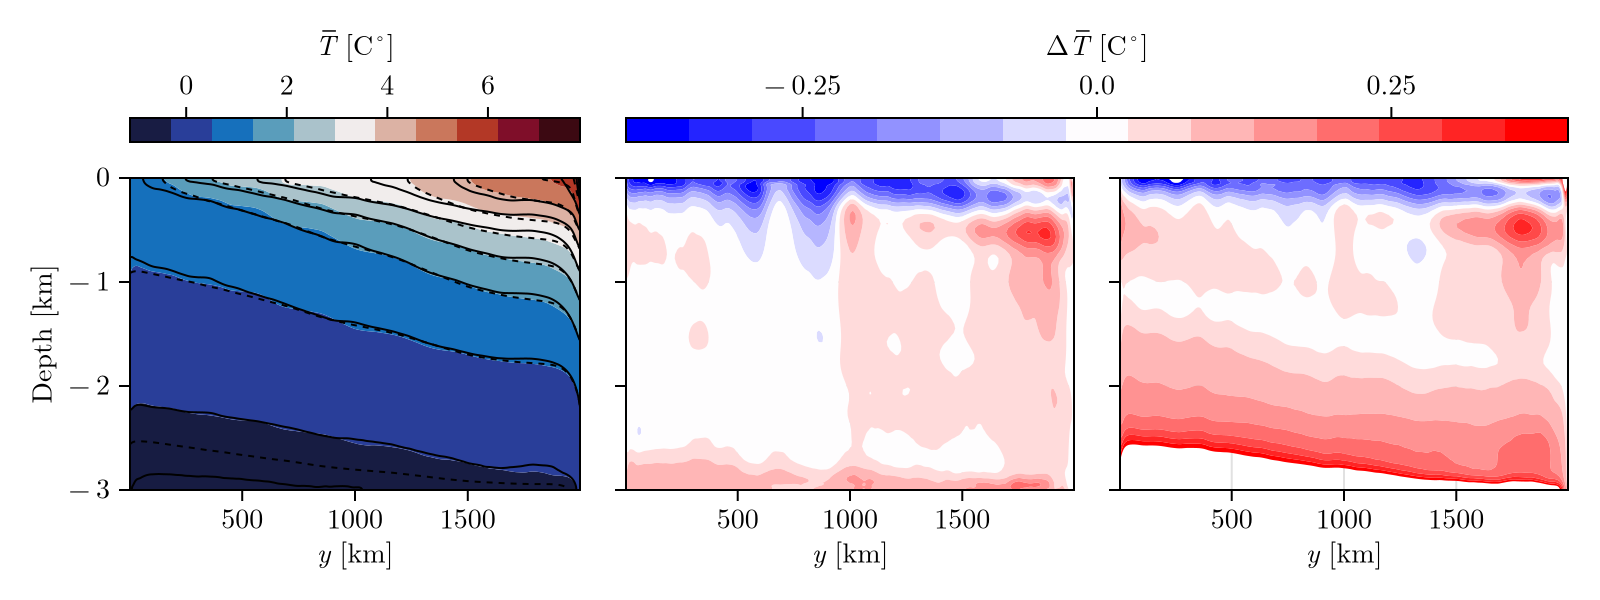

CairoMakie.Screen{PDF}


In [107]:
fig = Figure(size = (800, 300))
yC = al.Abx.grid.yᵃᶜᵃ[1:400] ./ 1000

 C = 1 / (2e-4 * 10)
xlabel = L"y \text{ [km]}"
xticks = ticks([0, 500, 1000, 1500])
ax1 = Axis(fig[1, 1]; xticks, xlabel, ylabel = L"\text{Depth [km]}", yticks = ticks([-3, -2, -1, 0]))
ax2 = Axis(fig[1, 2]; xticks, xlabel, ylabel = "", yticks = ([-3, -2, -1, 0], ["", "", "", ""]))
ax3 = Axis(fig[1, 3]; xticks, xlabel, ylabel = "", yticks = ([-3, -2, -1, 0], ["", "", "", ""]))

hm = contourf!(ax1, yC, zC, interior(mean(al.b[end], dims=1), 1, :, :) .* C, levels = range(-0.00223439, 0.0156607, length=12) .* C, colormap = :balance)
contour!(ax1,  yC, zC, interior(mean(rl.b[end], dims=1), 1, :, :) .* C, levels = range(-0.00223439, 0.0156607, length=12) .* C, color = :black)
contour!(ax1,  yC, zC, interior(mean(r3.b[end], dims=1), 1, :, :) .* C, levels = range(-0.00223439, 0.0156607, length=12) .* C, color = :black, linestyle=:dash)
Colorbar(fig[0, 1], hm, vertical=false, ticks=ticks([0, 2, 4, 6, 8]), label = L"\overline{T} \text{ [C}^\circ\text{]}")
ylims!(ax1, -3, 0)
xlims!(ax1, yC[1], yC[end])

contourf!(ax2, yC, zC, (interior(mean(al.b[end], dims=1), 1, :, :) .- interior(mean(rl.b[end], dims=1), 1, :, :)) .* C, levels = range(-0.0008, 0.0008, length=16) .* C, colormap = :bwr)
ylims!(ax2, -3, 0)
xlims!(ax2, yC[1], yC[end])

hm = contourf!(ax3, yC, zC, (interior(mean(r3.b[end], dims=1), 1, :, :) .- interior(mean(rl.b[end], dims=1), 1, :, :)) .* C, levels = range(-0.0008, 0.0008, length=16) .* C, colormap = :bwr)
ylims!(ax3, -3, 0)
xlims!(ax3, yC[1], yC[end])
Colorbar(fig[0, 2:3], hm, vertical=false, ticks=ticks([-0.25, 0.0000, 0.25]), label = L"\Delta \overline{T} \text{ [C}^\circ\text{]}")
display(fig)

display(current_figure())
CairoMakie.save(path * "mean-channel.pdf", fig)


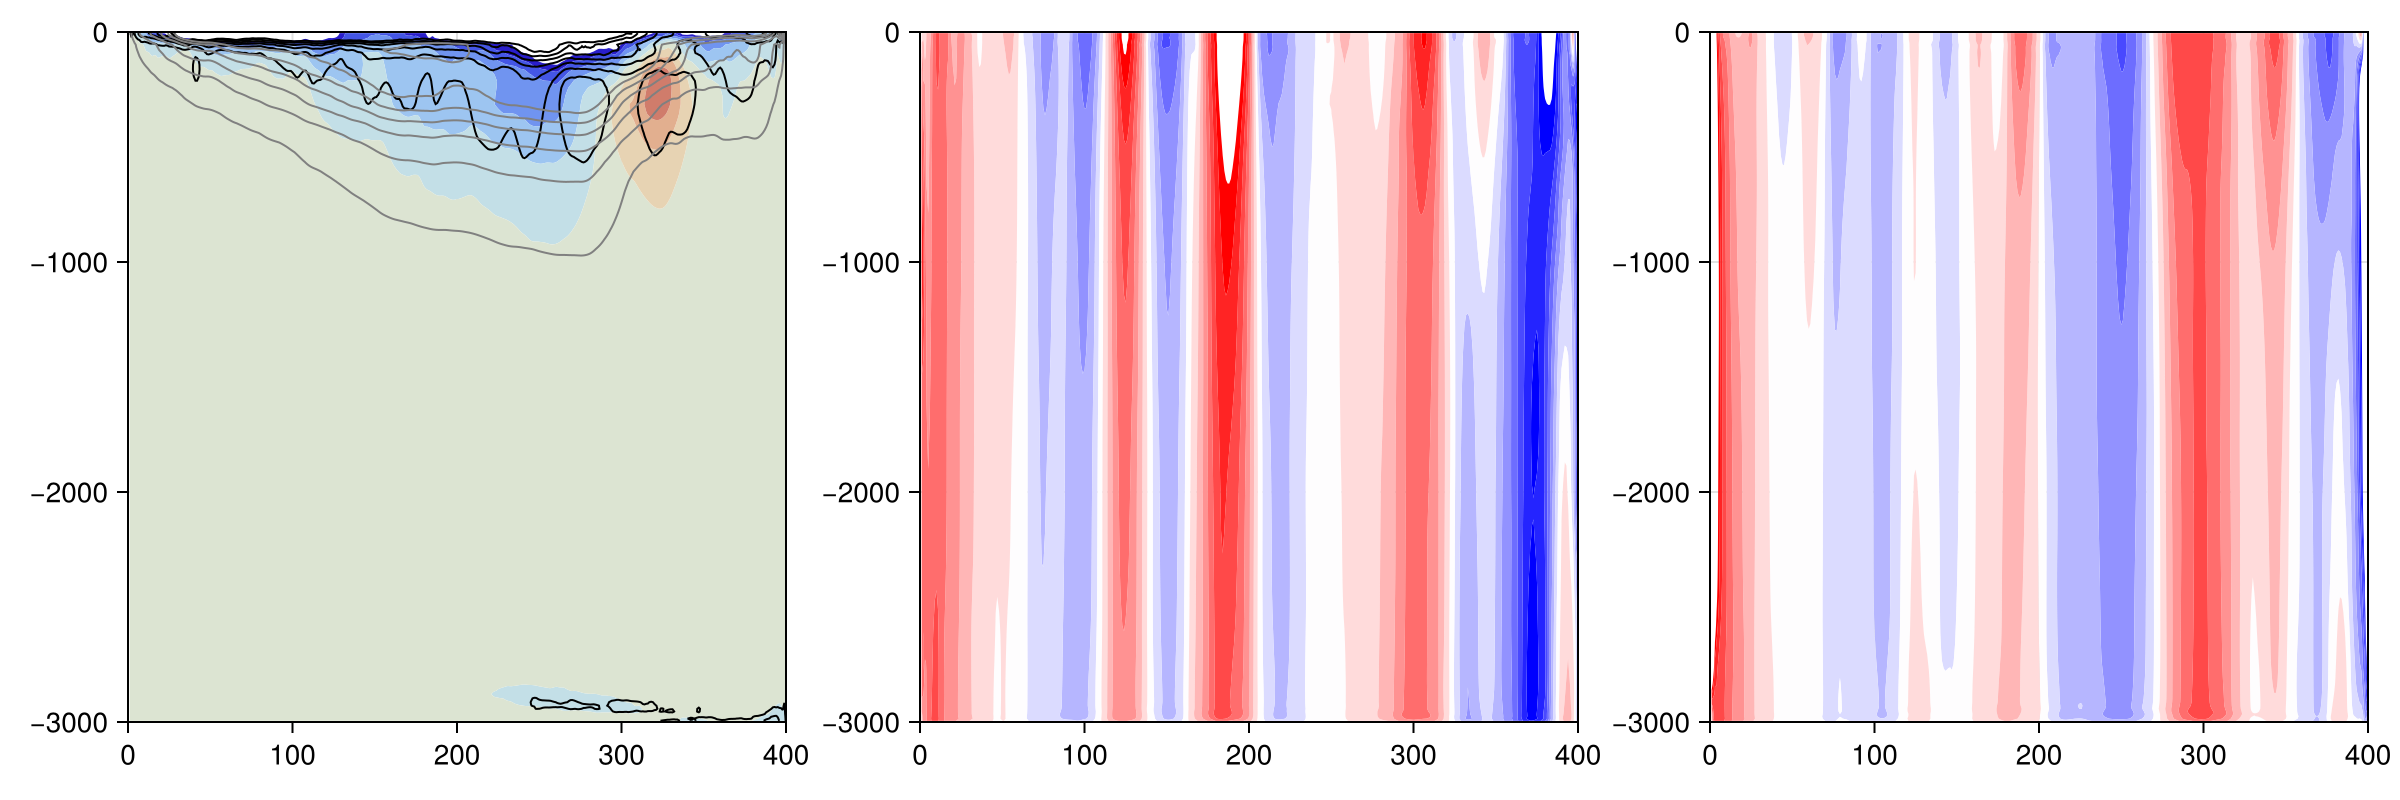

CairoMakie.Screen{IMAGE}


In [57]:
fig = Figure(size = (1200, 400))
ax = Axis(fig[1, 1])
contourf!(ax, 1:400, zC, interior(mean(al.Abx[end], dims=1), 1, :, :), levels = range(-1e-5, 1e-5, length=12), colormap = :thermometer)
contour!(ax,  1:400, zC, interior(mean(rl.Abx[end], dims=1), 1, :, :), levels = range(-1e-5, 1e-5, length=12), color = :black)
contour!(ax,  1:400, zC, interior(mean(r3.Abx[end], dims=1), 1, :, :), levels = range(-1e-5, 1e-5, length=12), color = :grey)
xlims!(ax, 0, 400)
ylims!(ax, -3000, 0)
ax = Axis(fig[1, 2])
contourf!(ax, 1:400, zC, interior(mean(al.u[end], dims=1), 1, :, :) .- interior(mean(rl.u[end], dims=1), 1, :, :), levels = range(-0.1, 0.1, length=16), colormap = :bwr)
xlims!(ax, 0, 400)
ylims!(ax, -3000, 0)
ax = Axis(fig[1, 3])
contourf!(ax, 1:400, zC, interior(mean(r3.u[end], dims=1), 1, :, :) .- interior(mean(rl.u[end], dims=1), 1, :, :), levels = range(-0.1, 0.1, length=16), colormap = :bwr)
xlims!(ax, 0, 400)
ylims!(ax, -3000, 0)
display(fig)

In [56]:
sum(r3.u[end]^2 + r3.v[end]^2)

611661.6376678672